# Tracing

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 14] 

In [44]:
def parse_trace(di, fix = 0):
    trace = pd.DataFrame(columns=["event", "id", "ts", "location"])

    for dirpath, dnames, fnames in os.walk(di):
        for f in fnames:
            if f.endswith(".csv"):
                t = pd.read_csv(os.path.join(dirpath, f), header=None, names=['event', 'id', 'ts'])
                t['location'] =  os.path.splitext(f)[0]
                trace = pd.concat([trace, t])
    trace = trace.set_index("id")
    return trace

In [78]:
def delay_between(trace, from_event, to_event, from_location = None, to_location = None):
    joined = trace.join(trace, lsuffix='_from', rsuffix='_to', how='inner')
    filtered = joined[(joined['event_from'] == from_event) & (joined['event_to'] == to_event)]
    if from_location is not None:
        filtered = filtered[filtered['location_from'] == from_location]
    if to_location is not None:
        filtered = filtered[filtered['location_to'] == to_location]
    return np.array((filtered['ts_to'] - filtered['ts_from']).unique(), dtype=np.int64) / 1e6

In [79]:
acker_away = parse_trace("traces/acker_away")
acker_same = parse_trace("traces/acker_same")
acker_away['event'].unique()

array(['rear-receive', 'ack-create', 'grouping-out', 'inject',
       'grouping-in', 'ack-receive', 'sink-send', 'front-send',
       'remote-send', 'accept'], dtype=object)

In [82]:
base_location = 'trace'
for location in acker_away['location'].unique():
    d = delay_between(acker_away, 'ack-create', 'ack-receive', from_location=None, to_location=base_location)
    trace[location] - 

-5.819752


# Networking after shuffle

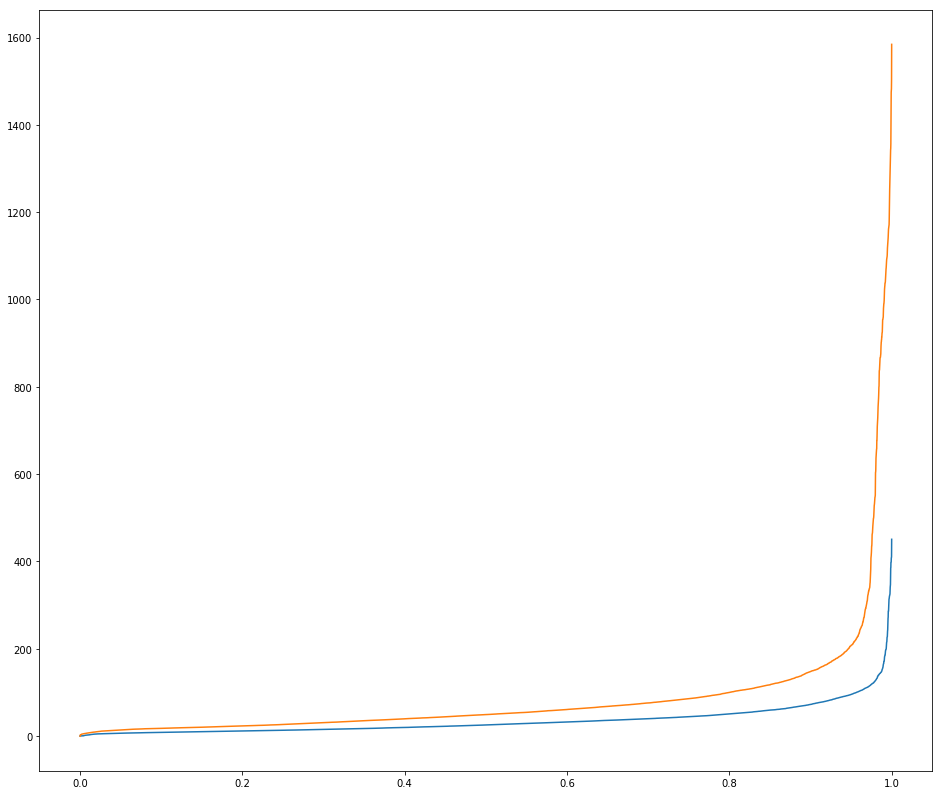

In [12]:
remote_send_acker_away = delay_between(acker_away, 'remote-send', 'inject') + 5
remote_send_acker_same = delay_between(acker_same, 'remote-send', 'inject') + 18

q1 = np.linspace(0, 1, np.size(remote_send_acker_away))
q2 = np.linspace(0, 1, np.size(remote_send_acker_same))

plt.plot(q1, np.sort(remote_send_acker_away), q2, np.sort(remote_send_acker_same))
plt.show()

In [181]:
pd.DataFrame(remote_send_acker_away).describe()

,0
count,6725.000000
mean,35.352040
std,36.309985
min,0.143730
25%,13.329520
50%,25.475548
75%,44.541140
max,450.709440


In [182]:
pd.DataFrame(remote_send_acker_same).describe()

,0
count,6938.000000
mean,84.384102
std,146.354713
min,-0.311772
25%,26.590559
50%,49.234744
75%,85.620524
max,1584.335007


# Acks

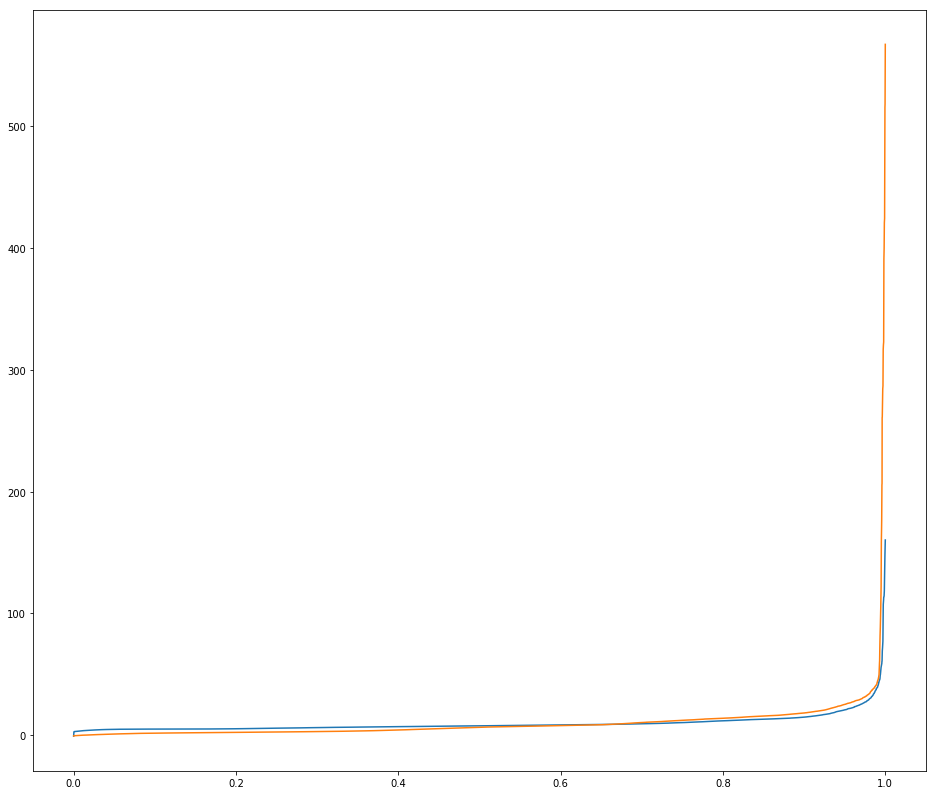

In [193]:
ack_acker_away = delay_between(acker_away, 'ack-create', 'ack-receive') + 5
ack_acker_same = delay_between(acker_same, 'ack-create', 'ack-receive') + 0

q1 = np.linspace(0, 1, np.size(ack_acker_away))
q2 = np.linspace(0, 1, np.size(ack_acker_same))

plt.plot(q1, np.sort(ack_acker_away), q2, np.sort(ack_acker_same))
plt.show()

In [191]:
pd.DataFrame(ack_acker_away).describe()

,0
count,6777.000000
mean,9.654799
std,8.796992
min,-0.819752
25%,5.780066
50%,7.711393
75%,10.325641
max,160.288821


In [192]:
pd.DataFrame(ack_acker_same).describe()

,0
count,6997.000000
mean,10.182313
std,25.922601
min,-0.619741
25%,2.643971
50%,6.552689
75%,12.221234
max,567.322296
